## Keras model 
---- 
* **Why Keras ? **


 > 실질적으로 풀려는 문제가 풀리는 문제 일까 아닐까를 정의가 안된 시점에서, 얕은 모델 부터 깊고 복잡한 모델까지 모두 실험해 보기 위해서 모델을 만들고 러닝 하여, 결과를 확인하는 과정에 사이클을 짧게 하기위함이 첫번째 이유이고, 두번째는 데이터를 직접 resizing하지 않아서 tfrecord로 파싱하는데 오류가 있었기 때문이다. 
 
* **현재 모델**
> **VGG alike** : 맨 처음 1x1conv layer로 gray scals 을 만들고 다음 VGG와 비슷한 구조로 conv을 수행한 후 FCN으로 넘어간다. 


> thinner와 다른점 
 1.한층(conv + conv + pool layers)을 더 해보자 .
 2.padding : same -> valid (조금씩 차원을 줄여보기 위함)


In [1]:
import numpy as np 
import pickle 

# load dataset 
with open('../sample_image/sample560_crop_df.bin', 'rb') as f :
    crop_img = pickle.load(f)

X = np.array([i for i in crop_img.crop_images])
y = crop_img.weight.values

In [2]:
#Parameters 

BATCH_SIZE = 24

In [3]:
### test/train split 
idx = list(np.random.randint(0, len(X), int(len(X) * 0.8)))
test_idx = list(set(list(range(len(X)))) - set(idx))

X_train = X[idx]
y_train = y[idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [4]:
# image augmentation 
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

gen.fit(X_train, augment=True)

Using TensorFlow backend.


In [1]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.layers import Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2


def cnn_model():
    model = Sequential()
    #  first layer for making images to the gray scale images, more precisely 
    model.add(Conv2D(1, (1, 1), activation='relu', input_shape=(250, 550, 3), padding='same', kernel_regularizer=l2(0.001)))

    # 
    model.add(Conv2D(32, (7, 7), activation='relu', padding='valid'))
    model.add(Conv2D(32, (7, 7), activation='relu', padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(32, (7, 7), activation='relu', padding='valid', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(32, (7, 7), activation='relu', padding='valid', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(32, (7, 7), activation='relu', padding='valid', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(32, (7, 7), activation='relu', padding='valid', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (7, 7), activation='relu', padding='valid', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (7, 7), activation='relu', padding='valid', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(200, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    return model 



Using TensorFlow backend.


In [2]:
from keras.utils.training_utils import multi_gpu_model

model = cnn_model()
model = multi_gpu_model(model, gpus=2)
model.outputs

# model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['mae'])

[<tf.Tensor 'dense_2_1/concat:0' shape=(?, 1) dtype=float32>]

In [7]:
%%time
hist = model.fit_generator(gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                           steps_per_epoch=len(X_train)/BATCH_SIZE,
                          epochs=200, validation_data=(X_test, y_test), verbose=2)

Epoch 1/200
 - 27s - loss: 5550.4092 - mean_absolute_error: 61.9416 - val_loss: 12123.2748 - val_mean_absolute_error: 109.5184
Epoch 2/200
 - 18s - loss: 1977.4438 - mean_absolute_error: 32.4925 - val_loss: 12123.3998 - val_mean_absolute_error: 109.5184
Epoch 3/200
 - 18s - loss: 1052.3870 - mean_absolute_error: 24.5205 - val_loss: 9681.2191 - val_mean_absolute_error: 96.5086
Epoch 4/200
 - 18s - loss: 560.2244 - mean_absolute_error: 17.8720 - val_loss: 9722.0285 - val_mean_absolute_error: 91.4916
Epoch 5/200
 - 18s - loss: 465.7534 - mean_absolute_error: 16.6885 - val_loss: 6655.0120 - val_mean_absolute_error: 69.2284
Epoch 6/200
 - 18s - loss: 424.8921 - mean_absolute_error: 16.1530 - val_loss: 4286.3692 - val_mean_absolute_error: 36.9306
Epoch 7/200
 - 17s - loss: 366.1788 - mean_absolute_error: 15.1319 - val_loss: 3357.2686 - val_mean_absolute_error: 51.1708
Epoch 8/200
 - 18s - loss: 378.6024 - mean_absolute_error: 15.2091 - val_loss: 13234.5930 - val_mean_absolute_error: 81.6356


Epoch 67/200
 - 18s - loss: 190.1188 - mean_absolute_error: 11.0102 - val_loss: 174.8030 - val_mean_absolute_error: 10.7402
Epoch 68/200
 - 18s - loss: 227.3381 - mean_absolute_error: 12.0045 - val_loss: 168.9351 - val_mean_absolute_error: 11.0591
Epoch 69/200
 - 17s - loss: 205.1249 - mean_absolute_error: 11.4783 - val_loss: 560.8298 - val_mean_absolute_error: 20.7213
Epoch 70/200
 - 17s - loss: 214.9036 - mean_absolute_error: 11.5622 - val_loss: 519.8965 - val_mean_absolute_error: 19.7235
Epoch 71/200
 - 17s - loss: 231.1629 - mean_absolute_error: 12.0270 - val_loss: 132.3230 - val_mean_absolute_error: 9.8400
Epoch 72/200
 - 17s - loss: 221.4099 - mean_absolute_error: 11.8824 - val_loss: 591.8205 - val_mean_absolute_error: 21.4128
Epoch 73/200
 - 17s - loss: 258.7965 - mean_absolute_error: 12.6633 - val_loss: 182.2742 - val_mean_absolute_error: 11.3635
Epoch 74/200
 - 18s - loss: 220.5064 - mean_absolute_error: 11.8337 - val_loss: 212.9302 - val_mean_absolute_error: 11.6315
Epoch 75/

 - 18s - loss: 180.7985 - mean_absolute_error: 10.5943 - val_loss: 288.0540 - val_mean_absolute_error: 14.7032
Epoch 134/200
 - 18s - loss: 194.4224 - mean_absolute_error: 10.9374 - val_loss: 142.2726 - val_mean_absolute_error: 10.4234
Epoch 135/200
 - 18s - loss: 181.2641 - mean_absolute_error: 10.6387 - val_loss: 166.6163 - val_mean_absolute_error: 11.0362
Epoch 136/200
 - 17s - loss: 187.0754 - mean_absolute_error: 10.7236 - val_loss: 161.3051 - val_mean_absolute_error: 10.9057
Epoch 137/200
 - 18s - loss: 196.2063 - mean_absolute_error: 11.3876 - val_loss: 284.0298 - val_mean_absolute_error: 13.9541
Epoch 138/200
 - 17s - loss: 182.1673 - mean_absolute_error: 10.8285 - val_loss: 209.4175 - val_mean_absolute_error: 12.3174
Epoch 139/200
 - 18s - loss: 183.5193 - mean_absolute_error: 10.8987 - val_loss: 255.0410 - val_mean_absolute_error: 13.3358
Epoch 140/200
 - 17s - loss: 173.8867 - mean_absolute_error: 10.4167 - val_loss: 262.8882 - val_mean_absolute_error: 13.0617
Epoch 141/200


Epoch 199/200
 - 18s - loss: 161.1734 - mean_absolute_error: 10.0287 - val_loss: 319.9639 - val_mean_absolute_error: 13.6930
Epoch 200/200
 - 17s - loss: 166.5440 - mean_absolute_error: 10.2413 - val_loss: 167.7534 - val_mean_absolute_error: 10.3791
CPU times: user 1h 26min 3s, sys: 12min 8s, total: 1h 38min 11s
Wall time: 59min 46s


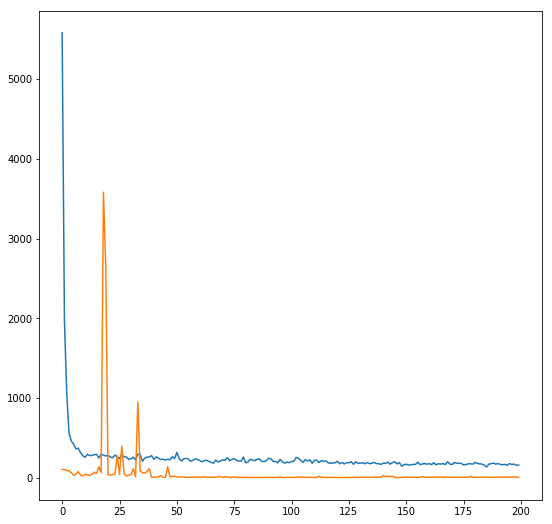

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(9,9))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_mean_absolute_error"])
plt.show()

In [19]:
r = 2
print("prediction : {}, Truth : {} ".format(model.predict(X_test)[r], y_test[r]))

prediction : [112.71926], Truth : 120.6 
